In [2]:
from rfpimp import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
banned = pd.read_csv('data/ban_df.csv', converters={'comments': eval})
subs = pd.read_csv('data/df_watchexchange.csv', converters={'comments': eval})
banned['is_scammer'] = True
subs['is_scammer'] = False

df = pd.concat([banned,subs],ignore_index = True)
df = df.drop(columns=['len_cs'])

In [4]:
import language_check
tool = language_check.LanguageTool('en-US')
text = 'A sentence with a error in the Hitchhiker’s Guide tot he Galaxy'
matches = tool.check(text)
len(matches)

2

In [ ]:
# did not use
# import re
# myString = "I want to Remove all white \t spaces, new lines \n and tabs \t"
# re.sub(r"[\n\t]*", "", myString)

In [7]:
def grammar_check(row):
    errors = []
    for comment in row:
        errors.append(len(tool.check(comment.replace('\n', ' '))))
    return (np.average(errors), np.sum(errors))

In [18]:
df['grammar'] = df['comments'].map(grammar_check)

KeyboardInterrupt: 

In [ ]:
import IPython
IPython.display.Audio("train.mp3", autoplay=True)

In [9]:
from collections import Counter

my_word = "HelLo WorLd"
c = Counter("upper" if x.isupper() else "lower" if x.islower() else "" for x in my_word)
print(c)
c['upper']/(c['lower']+c['upper'])

Counter({'lower': 6, 'upper': 4, '': 1})


0.4

In [ ]:
from collections import Counter
word = 'HELLO'
c = Counter("upper" if x.isupper() for x in word)
c['upper']/len(word)


In [13]:
def caps(row):
    caps = []
    for comment in row:
        c = Counter("upper" if x.isupper() else "lower" if x.islower() else "special" for x in comment)
        caps.append(c['upper']/(c['lower']+c['upper']))
    return caps

In [ ]:
def caps(row):

In [14]:
df['comments'][:2].map(caps)

0    [0.040229885057471264, 0.040229885057471264, 0...
1    [0.125, 0.25, 0.03296703296703297, 0.181818181...
Name: comments, dtype: object

In [15]:
df['caps'] = df['comments'].map(caps)

ZeroDivisionError: division by zero

In [20]:
def sniff(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['sample'] = df.iloc[0]
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        return info.sort_values('data type')


In [85]:
X=df.drop(columns=['users','comments','is_scammer'])
y=df['is_scammer']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20)

In [87]:
#random forest classifier
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True)

In [88]:
rf.fit(X_train , y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [92]:
y_pred = rf.predict_proba(X_test)[:,1]

In [95]:
roc_auc_score(y_test, y_pred)

0.8697741596638656

In [104]:
threshold = .50
predicted = y_pred >= threshold
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)

accuracy: 0.8090614886731392
precision: 0.6911764705882353
recall: 0.5529411764705883


Text(89.18, 0.5, 'predicted label')

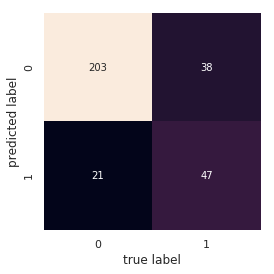

In [105]:
mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')


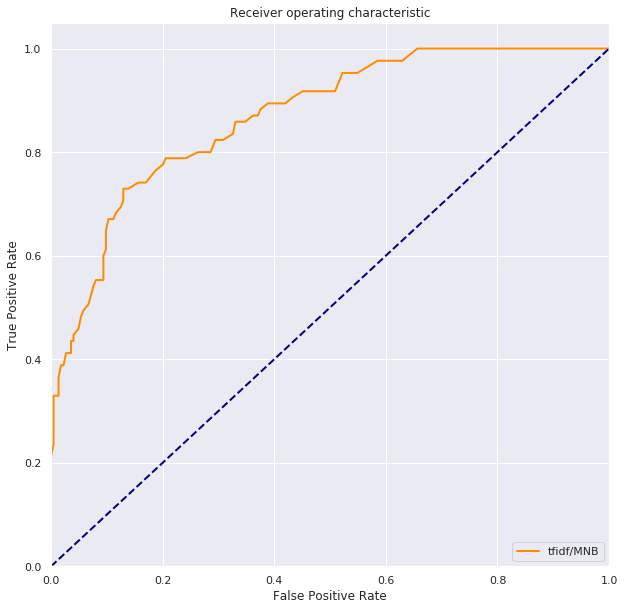

In [106]:
roc_y_test = y_test.map(int)
fpr, tpr, thresholds = roc_curve(roc_y_test, y_pred, pos_label=1)
fig,ax = plt.subplots(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='tfidf/MNB')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [53]:
import praw
reddit = praw.Reddit(user_agent='Comment History Parser',
                    client_id='nkVxbwp1RsHHCA',
                     client_secret='SlzWUhAhV5nIXPy4_1PTJSOaLrA')

In [84]:
df.verified.value_counts()

True     1208
False     336
Name: verified, dtype: int64

In [64]:
nan_users = test[pd.isnull(df).any(axis=1)]['users'].values
nan_users = [reddit.redditor(user) for user in nan_users]

In [66]:
verified = [user.verified for user in nan_users]

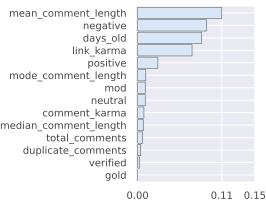

In [107]:
I = importances(rf, X_train, y_train)
plot_importances(I)

In [108]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred)

/home/richard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7810924369747899

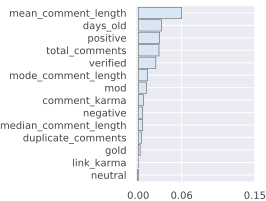

In [112]:
I = importances(lg, X_train, y_train)
plot_importances(I)

In [110]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred)

0.6886029411764706

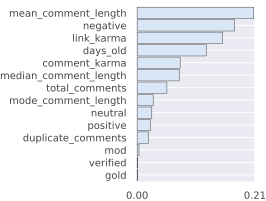

In [113]:
I = importances(dt, X_train, y_train)
plot_importances(I)

In [114]:
#GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.8608718487394957

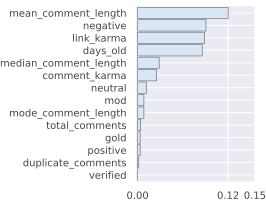

In [116]:
I = importances(gb, X_train, y_train)
plot_importances(I)

In [136]:
#LGBM
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred = lgb.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.8658088235294118

accuracy: 0.8187702265372169
precision: 0.6933333333333334
recall: 0.611764705882353


Text(89.18, 0.5, 'predicted label')

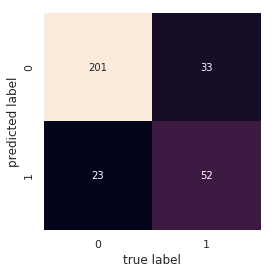

In [122]:
threshold = .50
predicted = y_pred >= threshold
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

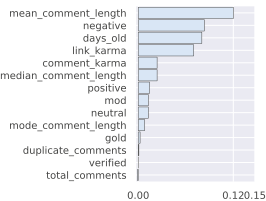

In [118]:
I = importances(gb, X_train, y_train)
plot_importances(I)

In [134]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.8618172268907563

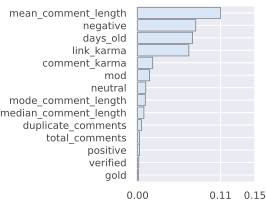

In [135]:
I = importances(xgb, X_train, y_train)
plot_importances(I)

In [127]:
#ensemble of RF, LGBM

df.iloc[321]

users                                                      sanders2016love
link_karma                                                             576
comment_karma                                                          418
verified                                                             False
mod                                                                  False
gold                                                                 False
days_old                                                              1304
comments                 [I miss him, Id protect it the lil jamal can g...
total_comments                                                         460
positive                                                          0.341304
neutral                                                            0.41087
negative                                                          0.247826
mean_comment_length                                                 41.637
mode_comment_length      

In [128]:
from sklearn.ensemble import VotingClassifier

In [150]:
eclf1 = VotingClassifier(estimators=[
         ('xgb', xgb), ('lgb', lgb), ('rf', rf)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)

In [151]:
eclf1.predict_proba(X_test)
y_pred = eclf1.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.8696428571428572

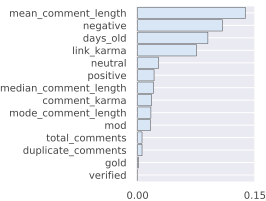

In [152]:
I = importances(eclf1, X_train, y_train)
plot_importances(I)

In [153]:
df.groupby('is_scammer').mean()

,link_karma,comment_karma,verified,mod,gold,days_old,total_comments,positive,neutral,negative,mean_comment_length,mode_comment_length,median_comment_length,duplicate_comments
is_scammer,,,,,,,,,,,,,,
False,3377.491480,4639.712108,0.828700,0.090583,0.060987,1529.622422,529.890583,0.548852,0.305084,0.146064,187.423518,74.506726,101.182511,21.257399
True,3114.585082,12564.270396,0.662005,0.216783,0.032634,1836.496503,534.979021,0.430924,0.370992,0.198083,139.069768,97.291375,94.504662,35.622378


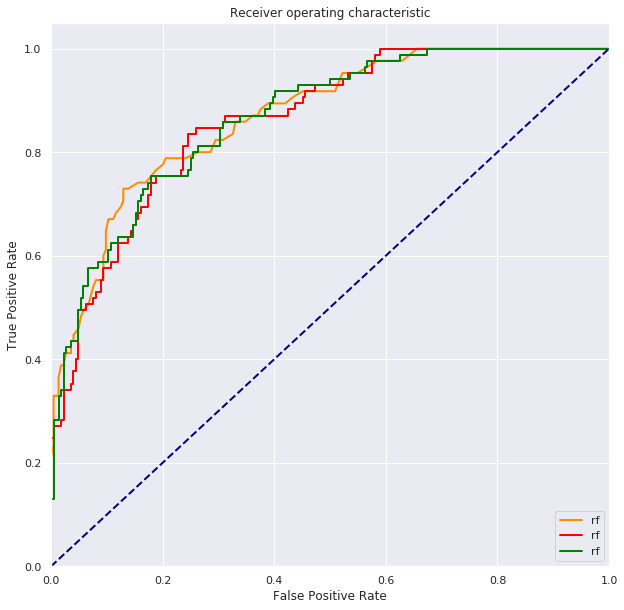

In [158]:
roc_y_test = y_test.map(int)
#rf
rf_y_pred = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(roc_y_test, rf_y_pred, pos_label=1)
fig,ax = plt.subplots(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='rf')
#xgb
xgb_y_pred = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(roc_y_test, xgb_y_pred, pos_label=1)
plt.plot(fpr, tpr, color='red',
         lw=2, label='xgb')
#lgb
lgb_y_pred = lgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(roc_y_test, lgb_y_pred, pos_label=1)
plt.plot(fpr, tpr, color='green',
         lw=2, label='lgb')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()